## Notebook de pruebas de CC y GCC en señales sinteticas

In [69]:
import numpy as np
import plot
import audio_functions as af
from scipy.signal import correlate
from scipy import signal
import pyroomacoustics as pra

Parametros generales:

In [70]:
c = 343    
fs=44100
duration = 0.1      # duracion de la señal

t = np.linspace(0, duration, int(fs * duration))

Ajustes de cantidad de microfonos y distancia entre ellos:

In [71]:
n_mics = 7
d = 0.1     # distancia entre micrófonos 

Ángulo de la señal que voy a generar artificialmente:

In [72]:
# Genero señales con retardos simulados para un ángulo de llegada dado
theta_deg = 60
theta = np.deg2rad(theta_deg)

Genero señales artificiales. Un pulso en t/2 y un pulso en un ambiente reverberado con un piso de ruido propio.
Ademas busco el delay de llegada entre microfonos a partir de la distancia y trigonometria. 
   
Señal A = Pulso unitario limpio  
Señal B = Pulso unitario con IR + Ruido rosa

In [ ]:
sample_delays = []

for i in range(n_mics):
    d_i = i * d                            # Distancia del micrófono i al micrófono de referencia (mic_0)
    delay_seg = (d_i * np.cos(theta)) / c  # Retardo en segundos 
    delay_samples = int(delay_seg * fs)          
    sample_delays.append(delay_samples)

# Genero señales 
pulse = np.zeros_like(t)
pulse[int(len(t)/2)] = 1.0

mic_signals = []

for delay in sample_delays:
    señal_retardada = np.roll(pulse, delay)  # Desplaza la señal 'pulse' en el tiempo simulando el retardo
    mic_signals.append(señal_retardada)      # Guarda la señal simulada en la lista

# Genero señales con ruido e IR sintética
mic_signals_rir = af.apply_reverb_synth(mic_signals, fs=fs, duration=duration, p_noise = 0.07, reverb_time=1, noise_floor_level=-250) 

# Parametros:
# Para ruido y Rir : Rir_A=0.3 y p_noise = 0.05, valores de prueba para ambiente con ruido alto
# Para ruido : rir_A = 0.1, p_noise = 0.07


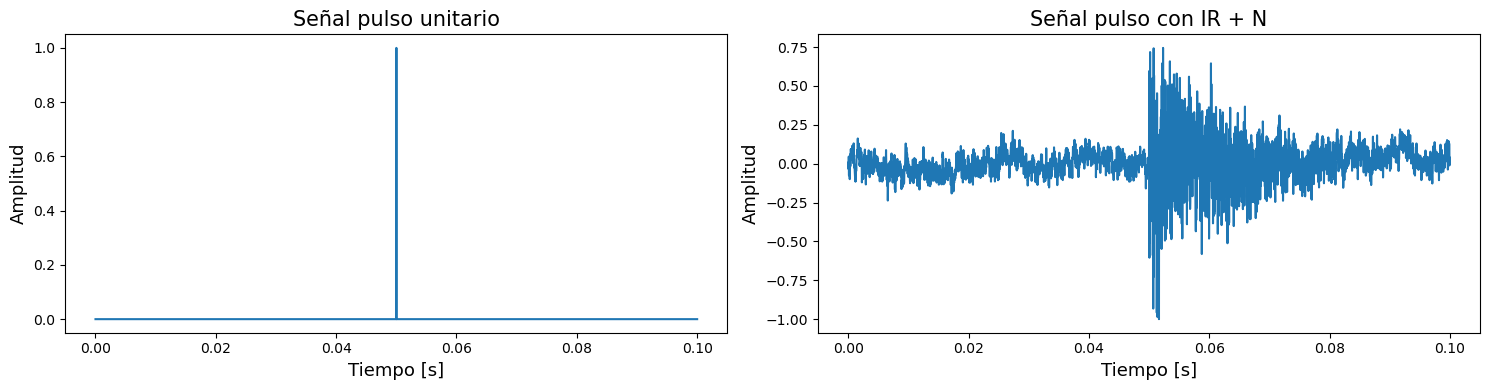

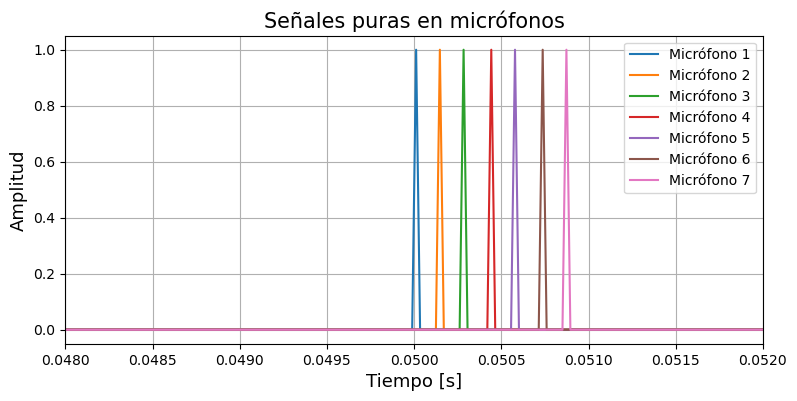

In [74]:
# Grafico señal limpia y con ruido
mic_pulse = lambda: plot.plot_signal({"time vector": t, "signal": mic_signals[0]}, title = "Señal pulso unitario", show=False)
mic_pulse_rir = lambda: plot.plot_signal({"time vector": t, "signal": mic_signals_rir[0]}, title = "Señal pulso con IR + N", show=False)

plot.multiplot(mic_pulse, mic_pulse_rir, figsize=(15, 4))

# Grafico todas las señales
plot_dicts = []

# Armo un diccionario de cada uno para plotear
for i, signal in enumerate(mic_signals):
    color = f"C{i}"  
    dic = {
        "time vector": t,
        "signal": signal,
        "label": f"Micrófono {i+1}",
        "color": color
    }
    plot_dicts.append(dic)

# Plot 
plot.plot_signal(*plot_dicts, title=f"Señales puras en micrófonos", 
                 grid=True, legend=True, figsize=(9, 4), xlimits=(0.048, 0.052))

Realizo cálculos con las señales obtenidas. Primero con la señal limpia busco la Correlación cruzada clásica (CC).

Obtengo una lista de taus y de angulos theta por cada microfono excepto del de referencia.  
De los ángulos obtenidos calculo el promedio y obtengo el ángulo final estimado.

In [75]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC = af.get_taus_n_mic(mic_signals, fs, mode= "Classic") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC = af.get_direction_n_signals(d,tau_list_CC, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC = (np.sum(est_theta_list_CC[1:])) / (len(est_theta_list_CC ) - 1)     # Promedio (no considero el inicial de referencia)

## Cálculos y Resultados

### Señal A - Pulso unitario

Resultados de la Señal A, Correlación cruzada clásica:

In [76]:
# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC, est_theta_list_CC)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.000113 s, Ángulo estimado = 67.11°
Mic 3: TDOA = 0.000249 s, Ángulo estimado = 64.67°
Mic 4: TDOA = 0.000408 s, Ángulo estimado = 62.18°
Mic 5: TDOA = 0.000544 s, Ángulo estimado = 62.18°
Mic 6: TDOA = 0.000703 s, Ángulo estimado = 61.17°
Mic 7: TDOA = 0.000839 s, Ángulo estimado = 61.34°
El ángulo promedio es: 63.11°


### Señal B - Pulso unitario con IR + Ruido

#### Señal B - Correlacion cruzada clásica

Con la señal B, busco tambien la CC.  
Muestro resultados de la señal con la IR asociada más ruido, Correlación cruzada clásica.

In [77]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "Classic") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.001950 s, Ángulo estimado = nan°
Mic 3: TDOA = -0.037846 s, Ángulo estimado = nan°
Mic 4: TDOA = 0.007574 s, Ángulo estimado = nan°
Mic 5: TDOA = -0.000045 s, Ángulo estimado = 92.23°
Mic 6: TDOA = 0.000816 s, Ángulo estimado = 55.94°
Mic 7: TDOA = 0.004717 s, Ángulo estimado = nan°
El ángulo promedio es: nan°


#### Señal B - PHAT

In [78]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "PHAT") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.001950 s, Ángulo estimado = nan°
Mic 3: TDOA = 0.001837 s, Ángulo estimado = nan°
Mic 4: TDOA = -0.000295 s, Ángulo estimado = 109.70°
Mic 5: TDOA = 0.005079 s, Ángulo estimado = nan°
Mic 6: TDOA = 0.000816 s, Ángulo estimado = 55.94°
Mic 7: TDOA = 0.001746 s, Ángulo estimado = 3.49°
El ángulo promedio es: nan°


### Señal B - SCOT

In [79]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "SCOT") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.001950 s, Ángulo estimado = nan°
Mic 3: TDOA = 0.001837 s, Ángulo estimado = nan°
Mic 4: TDOA = -0.000295 s, Ángulo estimado = 109.70°
Mic 5: TDOA = 0.005079 s, Ángulo estimado = nan°
Mic 6: TDOA = 0.000816 s, Ángulo estimado = 55.94°
Mic 7: TDOA = 0.001746 s, Ángulo estimado = 3.49°
El ángulo promedio es: nan°


### Señal B - ROTH

In [80]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "ROTH") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.001429 s, Ángulo estimado = nan°
Mic 3: TDOA = 0.001837 s, Ángulo estimado = nan°
Mic 4: TDOA = -0.000295 s, Ángulo estimado = 109.70°
Mic 5: TDOA = -0.010385 s, Ángulo estimado = nan°
Mic 6: TDOA = 0.016395 s, Ángulo estimado = nan°
Mic 7: TDOA = 0.003764 s, Ángulo estimado = nan°
El ángulo promedio es: nan°


### Pyroom

In [81]:
#Determino coeficiente de absorción 1 para simular campo libre y lo convierto en un material
abs_prom = pra.Material(1.0)

#Determino dimensiones y frecuencia de sampleo, dimensiones muy grandes para campo libre
room_dim = [5000, 5000, 5000]
fs = 44100

#Creo la habitación
room = pra.ShoeBox(room_dim, fs=fs, max_order=0, materials=abs_prom)

#Cargo el audio para poder asignarlo a la fuente
audio, _ =af.load_audio("audios_anecoicos/p336_023.wav")

#Agrego fuente a la sala
room.add_source([2500, 2250, 2502], signal=audio)

#Agrego array de mics a la sala
mic_array_loc = np.c_[[3000, 2000, 2501.2], [3000, 2500, 2501.2], [3000, 2750, 2501.2]]
room.add_microphone_array(mic_array_loc)
